[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18072.007591921174
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1674651.6741457777
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4300.772822846149
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4271.448920185222
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4404.609972673459
Iteration:      6,   Func. Count:     38,   Neg. LLF: 4305.677447669932
Iteration:      7,   Func. Count:     44,   Neg. LLF: 4252.950642425914
Iteration:      8,   Func. Count:     50,   Neg. LLF: 4252.616618079999
Iteration:      9,   Func. Count:     56,   Neg. LLF: 4252.551049075579
Iteration:     10,   Func. Count:     61,   Neg. LLF: 4252.550519612027
Iteration:     11,   Func. Count:     66,   Neg. LLF: 4252.550518341238
Iteration:     12,   Func. Count:     70,   Neg. LLF: 4252.550518340964
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4252.550518341238
            Iterations: 12

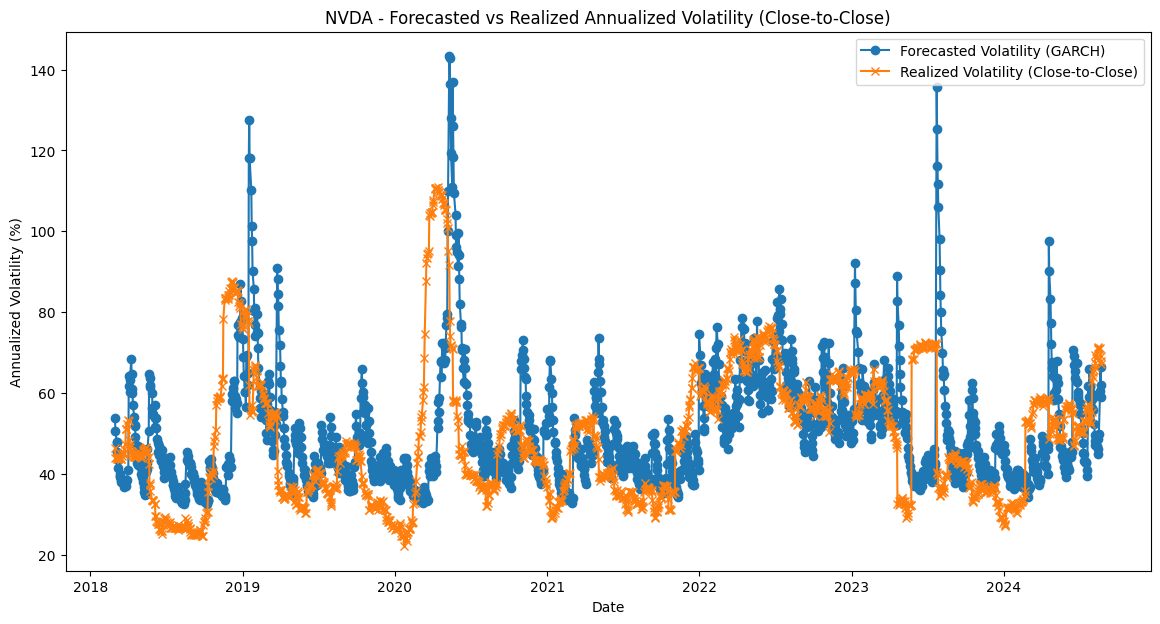

Mean Squared Error (MSE): 321.7365
Mean Absolute Error (MAE): 13.0129


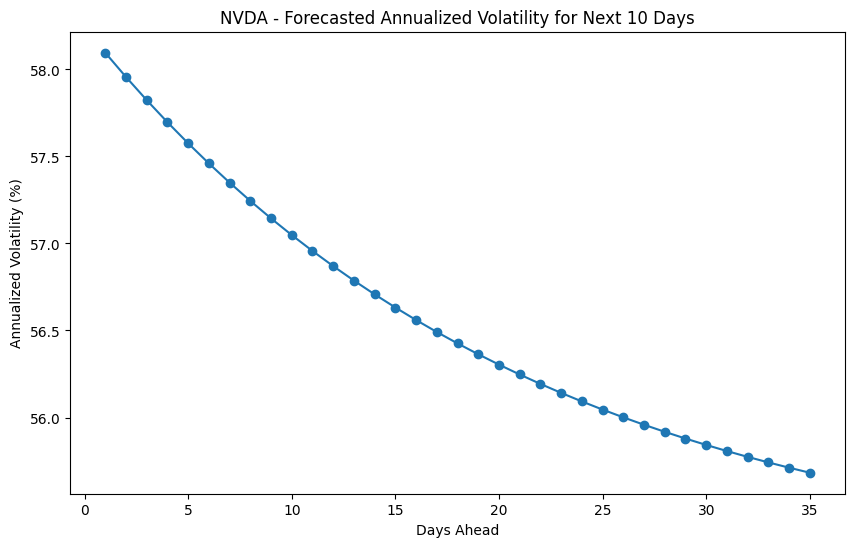

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# 1. Data Preparation
stock_symbol = 'NVDA'
start_date = '2018-01-01'
end_date = '2024-08-23'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate close-to-close returns
returns = 100 * stock_data['Close'].pct_change().dropna()

# Calculate realized volatility using close-to-close returns
def close_to_close_volatility(returns, window=40):
    return returns.rolling(window=window).std()

# Calculate realized volatility over the entire period
realized_volatility_cc = close_to_close_volatility(returns, window=40)

# Annualize the realized volatility
trading_days_per_year = 252
realized_annualized_volatility_cc = realized_volatility_cc * np.sqrt(trading_days_per_year)

# Drop NaN values from the realized volatility
realized_annualized_volatility_cc = realized_annualized_volatility_cc.dropna()

# Fit GARCH model on the entire period
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = garch_model.fit()

# Forecasting Volatility for the entire period
vol_forecast = model_fit.forecast(start=0, reindex=False)

# Extract the forecasted daily volatility (standard deviation)
forecasted_daily_volatility = np.sqrt(vol_forecast.variance.dropna().values.flatten())

# Convert to annualized volatility
forecasted_annualized_volatility = forecasted_daily_volatility * np.sqrt(trading_days_per_year)

# Align the lengths of both forecasted and realized volatilities
min_length = min(len(forecasted_annualized_volatility), len(realized_annualized_volatility_cc))
forecasted_volatility_trimmed = forecasted_annualized_volatility[:min_length]
realized_volatility_cc_trimmed = realized_annualized_volatility_cc[:min_length]

# Plotting the Comparison from start_date to end_date
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-min_length:], forecasted_volatility_trimmed, label='Forecasted Volatility (GARCH)', marker='o')
plt.plot(stock_data.index[-min_length:], realized_volatility_cc_trimmed.values, label='Realized Volatility (Close-to-Close)', marker='x')
plt.title(f'{stock_symbol} - Forecasted vs Realized Annualized Volatility (Close-to-Close)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.show()

# Calculate Error Metrics
mse = np.mean((forecasted_volatility_trimmed - realized_volatility_cc_trimmed.values) ** 2)
mae = np.mean(np.abs(forecasted_volatility_trimmed - realized_volatility_cc_trimmed.values))

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Forecasting Volatility for the next 10 days
forecast_horizon = 35
future_forecast = model_fit.forecast(horizon=forecast_horizon)

# Extract the forecasted daily volatility (standard deviation) for the next 10 days
forecasted_future_daily_volatility = np.sqrt(future_forecast.variance.iloc[-1].values)

# Convert to annualized volatility
forecasted_future_annualized_volatility = forecasted_future_daily_volatility * np.sqrt(trading_days_per_year)

# Plotting the Forecasted Volatility for the Next 10 Days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_future_annualized_volatility, marker='o')
plt.title(f'{stock_symbol} - Forecasted Annualized Volatility for Next 10 Days')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.show()
